In [83]:
cd /home/dsi/mbouchouia/code/git/PRIM/Notebooks/

/home/dsi/mbouchouia/code/git/PRIM/Notebooks


In [69]:
import sklearn
import itertools
from hyperopt import fmin, tpe,pyll, hp, Trials, STATUS_OK, STATUS_FAIL

from sklearn.metrics import r2_score

from importlib import reload

import numpy as np
import random
import sys
import io
import matplotlib.pyplot as plt
import urllib

import time
import sys
import pymongo
import os
sys.path.append('../scripts/')
sys.path.append('../papers code/DCRNN/')
import Plotting
import folium
import matplotlib
import osmMerger
import CustomUtils
import OsmProcessing
import datetime
import pandas as pd
from tf_cuda_subprocess import *
from   functools import reduce
import seaborn as sns
import models
from mongoConnection import *
sns.set()
results_path = "../images/model results/"
def saveFig():
    if not os.path.isdir(results_path+model_name):
        os.makedirs(results_path+model_name)
    print(results_path+model_name)
    plt.savefig(results_path+model_name+input(),dpi=300,bbox_inches='tight')

import tensorflow as tf

# @RunAsCUDASubprocess(num_gpus=1)
def createSession():
    config = tf.ConfigProto(intra_op_parallelism_threads=32, 
                            inter_op_parallelism_threads=32,
                            allow_soft_placement=True
                           )

    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    session = tf.Session(config=config,graph=tf.get_default_graph())

    tf.keras.backend.set_session(session)
createSession()
oldModelPlotting=None

### \begin{equation} Y_c^{(i)} = Y^{(i)} - n^{-1} \sum_{i=1}^n{Y^{(i)}} \end{equation}

In [70]:
speeds = pd.read_pickle("../data/monthsSpeed__0.pckl")

counts = pd.read_pickle('../data/monthsCount__0.pckl')
# speeds = pd.read_pickle("../data/monthsSpeedfullday__0.pckl")

# counts = pd.read_pickle('../data/monthsCountfullday__0.pckl')


mergeResults=pd.read_pickle("../data/mergeResults.pckl")
segmentsMeta=pd.read_pickle("../data/segmentsMeta.pckl")
mergedSegments=pd.read_pickle("../data/mergedSegments.pckl")

data_cleaner = models.DataCleaner(speeds,segmentsMeta,mergeResults,counts,0.80)

In [71]:
diffusion_matrix = pd.read_pickle("../data/all_dates_diffusion_matrix.pckl")
diffusion_matrix = diffusion_matrix/diffusion_matrix.sum()

In [72]:
speedDF = data_cleaner.data
countDF = data_cleaner.counts

In [73]:
adjacency_matrix = OsmProcessing.getAdjacencyMatrix(segmentsMeta)
adjacency_matrix = adjacency_matrix.add(adjacency_matrix.T.values,fill_value=0)
adjacency_matrix = OsmProcessing.addLevel(adjacency_matrix,3)
adjacency_matrix = OsmProcessing.mergeAdjacencyMatrix(adjacency_matrix, mergeResults, segmentsMeta)
adjacency_matrix = adjacency_matrix[speedDF.index].loc[speedDF.index]

In [74]:
adfullerDF = speedDF.groupby(pd.to_datetime(speedDF.columns).time,axis=1).agg(lambda x :x.apply(lambda y : models.smt.adfuller(y.values)[1],axis=1))
print((adfullerDF<0.05).sum().sum()/adfullerDF.size)
print((adfullerDF>0.05).sum().sum())
# plt.figure(figsize=(18,18))
# plt.imshow((adfullerDF>0.05)+0,aspect='auto')
# plt.grid(b=None)
# plt.colorbar()

0.949910071942446
557


In [75]:
""" we don't want to center using unseen data"""
valid_split = 0.7
sequence_length=len(set(pd.to_datetime(speedDF.columns).time))
n_dates=len(set(pd.to_datetime(speedDF.columns).date)) 
train_dates_index = speedDF.columns[:int(valid_split*n_dates)*sequence_length]
train_intercept=speedDF[train_dates_index].groupby(pd.to_datetime(train_dates_index).time,axis=1).mean()
intercept_extended_df= pd.concat([train_intercept]*n_dates,axis=1)
intercept_extended_df.columns=speedDF.columns
# centering
speedDF = speedDF-intercept_extended_df

In [9]:
# speedDF = speedDF*speedDF.apply(lambda x: (abs(x)<20).astype(int)if x.name.day<=11 and (x.name.month==2 or x.name.month==3) else (x>-1111).astype(int))

In [10]:
s=speedDF.loc[adfullerDF.mean(axis=1)>0.06] + intercept_extended_df.loc[adfullerDF.mean(axis=1)>0.06]

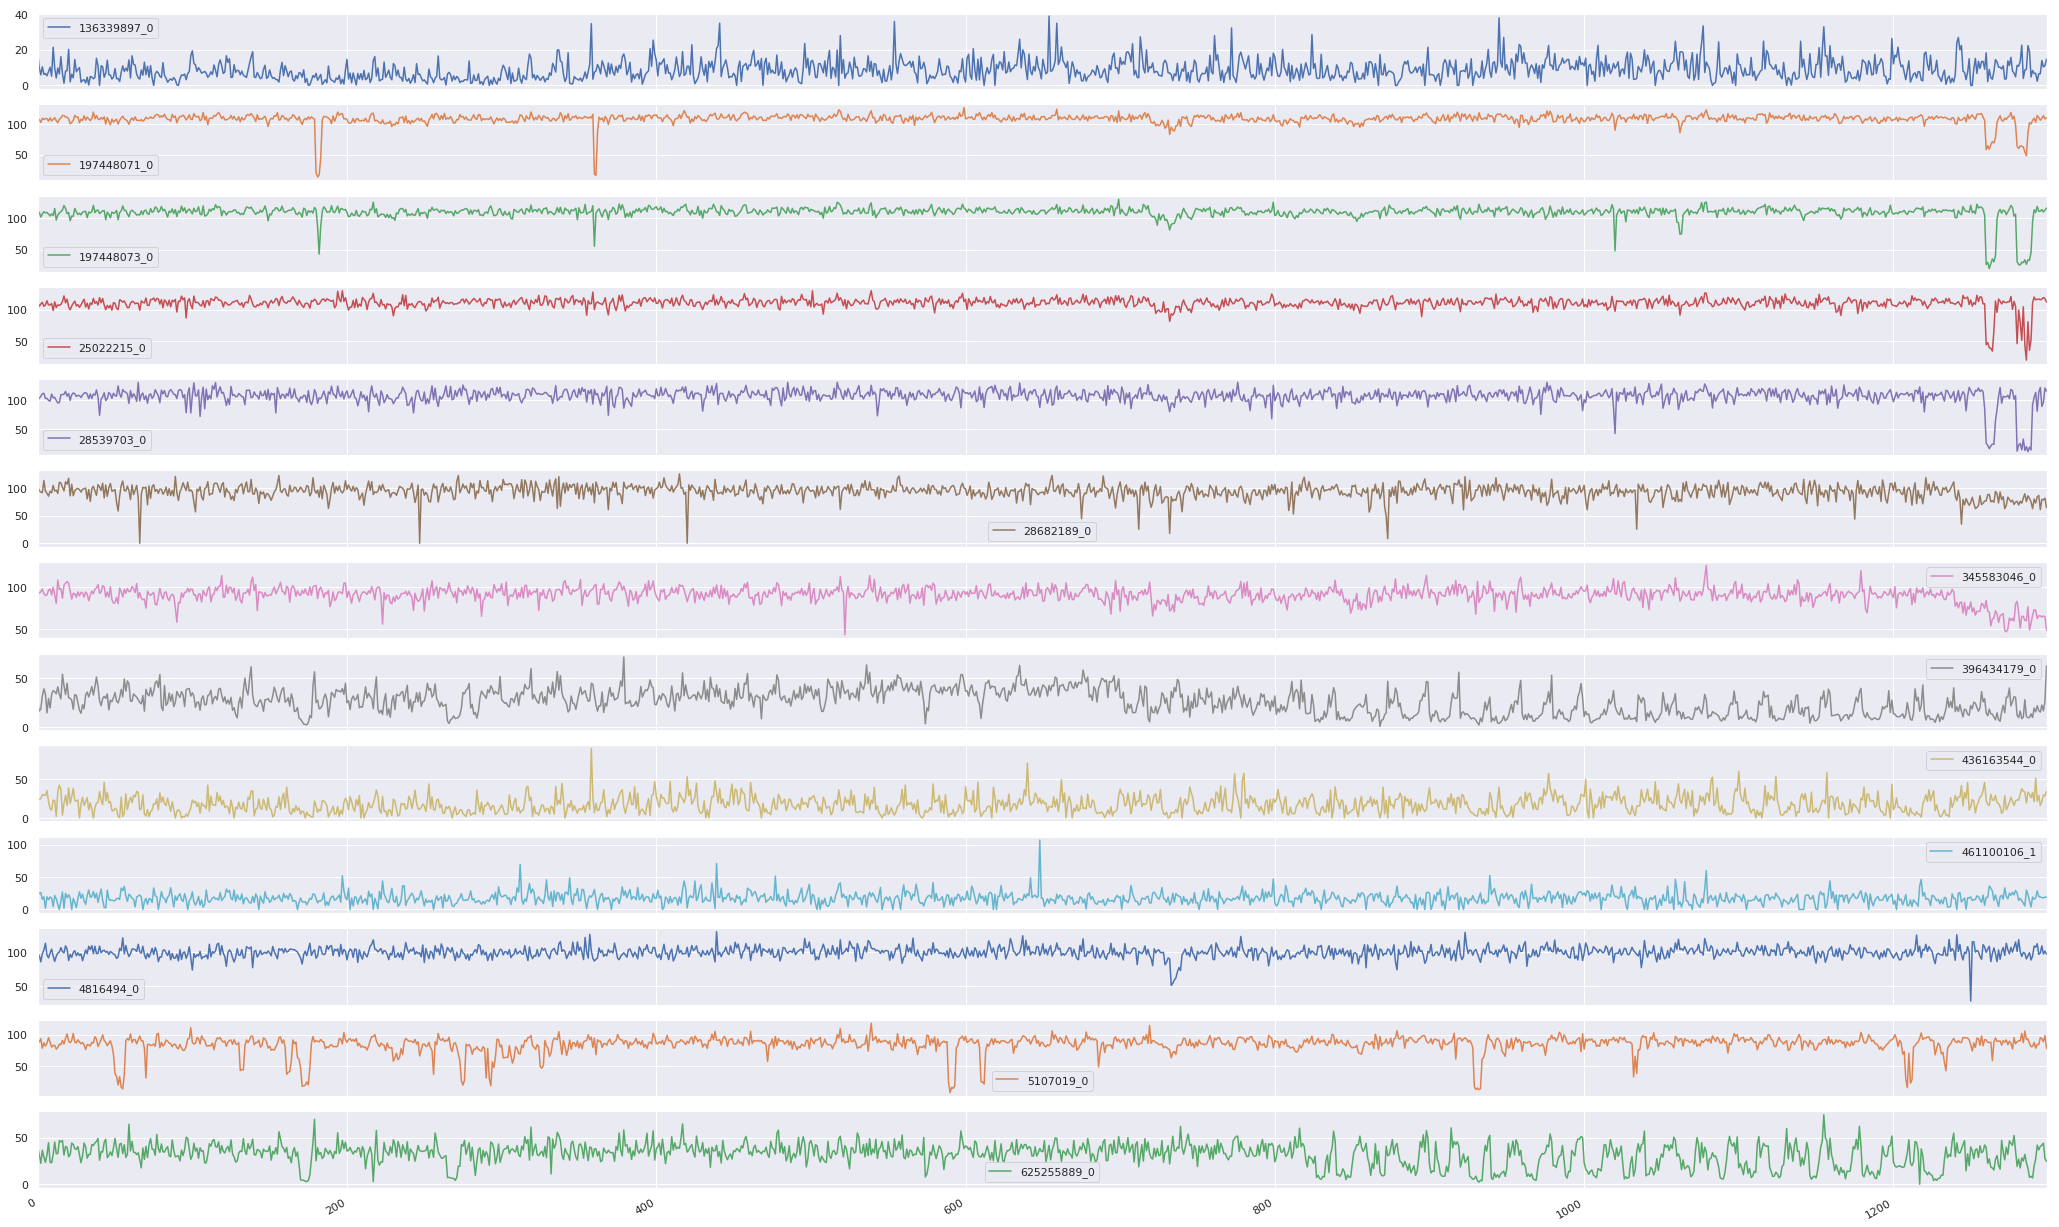

In [11]:
""" non-stationary segments plots"""
s.T.plot(figsize=(36,24),use_index=False,subplots=True);

In [12]:
def notSosSimpleMonoInput(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
#     time_dense = tf.keras.layers.Dense( nSegments, use_bias=False )(time_input)
    
    
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

    hidden = tf.keras.layers.Dense(100, use_bias = True, kernel_regularizer=tf.keras.regularizers.l1(l1_rate),activation="sigmoid")(flatten_input)
    

    

#     output_layer = tf.keras.layers.Dense(nSegments , name = "Output", use_bias = True)(hidden)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mae'] )

    data_model.model.summary()
    

In [13]:
# pruning_params = {
#       'pruning_schedule': sparsity.ConstantSparsity(.99,0,frequency=2)
# }


def simpleMonoInput(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
#     time_dense = tf.keras.layers.Dense( nSegments, use_bias=False )(time_input)
    
    
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

#     hidden = tf.keras.layers.Dense(100, use_bias = False, kernel_regularizer=tf.keras.regularizers.l1(l1_rate),activation="sigmoid")(flatten_input)
    
    output_layer = tf.keras.layers.Dense(nSegments, kernel_regularizer=tf.keras.regularizers.l1(l1_rate) , name = "Output", use_bias = False)(flatten_input)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
#     data_model.model=sparsity.prune_low_magnitude(  data_model.model, **pruning_params)
    
    data_model.model.compile( loss = "logcosh", optimizer = optimizer, metrics = ['mae','mse'] )

    data_model.model.summary()
    

In [14]:
# pruning_params = {
#       'pruning_schedule': sparsity.ConstantSparsity(.99,0,frequency=2)
# }


def simpleMonoInput(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
#     time_dense = tf.keras.layers.Dense( nSegments, use_bias=False )(time_input)
    
    
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

    output_layer = tf.keras.layers.Dense(nSegments, kernel_regularizer=tf.keras.regularizers.l1(l1_rate) , name = "Output", use_bias = False)(flatten_input)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
#     data_model.model=sparsity.prune_low_magnitude(  data_model.model, **pruning_params)
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mse'] )

    data_model.model.summary()
    

In [15]:
def deepMLPLasso(rate):
    
    """
    nSegments = len(speedDF)

    input_lag, output_lag, sequence_length = 1, 1, len(set(pd.to_datetime(speedDF.columns).time)) # speedDF.columns.size
    intercept_data_model = models.DataModel(intercept_extended_df,input_lag,output_lag,sequence_length,valid_split=valid_split)
    intercept_data_model.preprocessData()

    params        = { "scale_output" : True,'segmentWiseNormalization':True,"name":"MLP" }

    data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params)

    data_model.preprocessData()

    x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()

    count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)
    count_train_00, _, count_test_00, _ = count_data.trainSplit()

    tf.keras.backend.clear_session()
   
    deepMLPLasso(9.237986903597669e-07)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_mean_squared_error', factor = 0.5, verbose=1, patience=5, cooldown=5)
    early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_mean_squared_error', patience = 20, restore_best_weights=True)

    batch_size = 8

    modelHist = data_model.model.fit([x_train_00,train_days_00], [y_train_00], validation_data=([x_test_00,test_days_00],[y_test_00]), batch_size=batch_size,epochs=400, callbacks=[reduce_lr,early_stop])
    print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
    print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))
    
    """
    
    main_input = tf.keras.layers.Input( x_train_00.shape[1:], name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )
    hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(flatten_input)
    hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(hidden)

    output_layer=tf.keras.layers.Dense(nSegments, name="speed_lstm",kernel_regularizer = tf.keras.regularizers.l1(rate))( hidden)
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss="mse", optimizer=optimizer,metrics=["mse"])
    data_model.model.summary()

In [16]:
# pruning_params = {
#       'pruning_schedule': sparsity.ConstantSparsity(.99,0,frequency=2)
# }


def oneHiddenSimpleMonoInput(data_model,x_train,l1_rate):
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )
    hidden = tf.keras.layers.Dense(nSegments ,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1(l1_rate))(flatten_input)
    output_layer = tf.keras.layers.Dense(nSegments,kernel_regularizer=tf.keras.regularizers.l1(l1_rate) , name = "Output")(hidden)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
#     data_model.model=sparsity.prune_low_magnitude(  data_model.model, **pruning_params)
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mse'] )

    data_model.model.summary()
    

In [17]:



def oneHiddenSimpleMonoInputNormalized(data_model,x_train,l1_rate):
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )
    norm=tf.keras.layers.BatchNormalization()(flatten_input)
    hidden = tf.keras.layers.Dense(nSegments ,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1(l1_rate))(norm)
    norm=tf.keras.layers.BatchNormalization()(hidden)

    output_layer = tf.keras.layers.Dense(nSegments,kernel_regularizer=tf.keras.regularizers.l1(l1_rate) , name = "Output")(norm)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mse'] )

    data_model.model.summary()
    

In [18]:
def deepMLPLassoNormalized(data_model,x_train_00,rate):
    
    """
        params        = { "scale_output" : True,"name":"Lasso","scale_max":True }

    """
    
    main_input = tf.keras.layers.Input( x_train_00.shape[1:], name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )
    norm=tf.keras.layers.BatchNormalization()(flatten_input)

    hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(norm)
    norm=tf.keras.layers.BatchNormalization()(hidden)

    hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(norm)
    norm=tf.keras.layers.BatchNormalization()(hidden)

    output_layer=tf.keras.layers.Dense(nSegments, name="speed_lstm",kernel_regularizer = tf.keras.regularizers.l1(rate))( norm)
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss="mse", optimizer=optimizer,metrics=["mse"])
    data_model.model.summary()

In [19]:
# pruning_params = {
#       'pruning_schedule': sparsity.ConstantSparsity(.99,0,frequency=2)
# }


def simpleMonoInputNormalized(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
#     time_dense = tf.keras.layers.Dense( nSegments, use_bias=False )(time_input)
    
    
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

    output_layer = tf.keras.layers.Dense(nSegments, kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                                         activation='tanh',name = "Output", use_bias = False)(flatten_input)
    
    output_layer = tf.keras.layers.Add()([output_layer,flatten_input])
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
#     data_model.model=sparsity.prune_low_magnitude(  data_model.model, **pruning_params)
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mse'] )

    data_model.model.summary()
    

In [20]:
nSegments = len(speedDF)

input_lag, output_lag, sequence_length = 1, 1, len(set(pd.to_datetime(speedDF.columns).time)) # speedDF.columns.size
intercept_data_model = models.DataModel(intercept_extended_df,input_lag,output_lag,sequence_length,valid_split=valid_split)
intercept_data_model.preprocessData()

params        = { "scale_output" : True,"name":"Lasso","scale_max":True }

data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params)

data_model.preprocessData()

x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()

count_data = models.DataModel( countDF, input_lag, output_lag, sequence_length, valid_split = valid_split)

count_train_00, _, count_test_00, _ = count_data.trainSplit()

tf.keras.backend.clear_session()
# data_model.count_data = count_data

# data_model.time_data  =  data_model.getDaysTypes(onehot=True)

# train_days_00, test_days_00 =  data_model.getDaysTypes(onehot=True)
# oneHiddenSimpleMonoInputNormalized(data_model,x_train_00,l1_rate=0.009)

# deepMLPLassoNormalized(data_model,x_train_00,rate=1.5e-5)
simpleMonoInputNormalized( data_model,x_train_00,l1_rate=1.5e-6 ) #4e-2)

# oneHiddenSimpleMonoInput(data_model,x_train_00,l1_rate=0.005)
# simpleMonoInput(data_model,x_train_00,l1_rate=0.04)
# deepMLPLasso(9.237986903597669e-07)

W0703 14:19:00.535900 139661115807552 deprecation.py:506] From /home/infres/mbouchouia/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
speed_input (InputLayer)        [(None, 1, 556)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 556)          0           speed_input[0][0]                
__________________________________________________________________________________________________
Output (Dense)                  (None, 556)          309136      lambda[0][0]                     
__________________________________________________________________________________________________
add (Add)                       (None, 556)          0           Output[0][0]                     
                                                                 lambda[0][0]                 

In [21]:
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_mean_squared_error', factor = 0.5, verbose=1, patience=5, cooldown=5)
early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_mean_squared_error', patience = 15, restore_best_weights=True)

batch_size = 8

modelHist = data_model.model.fit([x_train_00,train_days_00], [y_train_00], validation_data=([x_test_00, test_days_00],[y_test_00]), batch_size=batch_size,epochs=400, callbacks=[reduce_lr,early_stop])
print(data_model.mse(data_model.predict('train'), y_train_00), data_model.mse(data_model.predict('test'),y_test_00))
print(data_model.mae(data_model.predict('train'), y_train_00), data_model.mae(data_model.predict('test'),y_test_00))

NameError: name 'train_days_00' is not defined

In [ ]:
y_train_00.shape

In [ ]:
i=(x for x in range(10))
[(plt.plot(sorted(x.flatten()),label=str(next(i))),plt.legend())for x in data_model.model.get_weights()];

In [ ]:
[x.shape for x  in data_model.model.get_weights()]

In [ ]:
plt.figure(figsize=(18,18))
plt.subplot(121)

A = data_model.model.get_weights()[-1]
plt.imshow(A)
plt.colorbar()
plt.subplot(122)

# plt.figure(figsize=(18,18))
plt.imshow((adjacency_matrix-3).clip(0))


### baseline comparison 

In [81]:
input_lag = 5

In [34]:

params        = {"name":"lastValue"}

lastValue_data_model = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
lastValue_data_model.preprocessData()

model = models.BaseModels("lastValue",historic_data = speedDF[speedDF.columns[:int(valid_split*speedDF.shape[1])]])
lastValue_data_model.model=model




lastValue_model_plotting = models.ModelPlots(lastValue_data_model, data_cleaner)


In [35]:

params        = {"name" : "timeHistoric"}

timehistoric_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
timehistoric_data_model.preprocessData()

model =models.BaseModels("timeHistoric",historic_data=speedDF[speedDF.columns[:int(valid_split*speedDF.shape[1])]])
timehistoric_data_model.model=model


In [36]:

params        = {"name":"historic"}

historic_data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params )
historic_data_model.preprocessData()

model =models.BaseModels("historic",historic_data=speedDF[speedDF.columns[:int(valid_split*speedDF.shape[1])]])
historic_data_model.model=model


In [37]:
AR_data_models ={}
for i in range(1,input_lag+1):
    params        = {"name":"AR "+str(i)}
    AR_data_models[i]=models.DataModel( speedDF,    i, output_lag, sequence_length, valid_split = valid_split, **params )
    AR_data_models[i].preprocessData()
    model =models.BaseModels("AR5",historic_data=speedDF[speedDF.columns[:int(valid_split*speedDF.shape[1])]],lag=i)
    AR_data_models[i].model=model


Training the AR(5) model
Train data shape: (556, 909)

Filling the voids...
Filling done. New train data shape: (556, 6921)

Training the models...
Params: max_lag: 1


/home/infres/mbouchouia/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)



Training finished !
Training the AR(5) model
Train data shape: (556, 909)

Filling the voids...
Filling done. New train data shape: (556, 6921)

Training the models...
Params: max_lag: 2

Training finished !
Training the AR(5) model
Train data shape: (556, 909)

Filling the voids...
Filling done. New train data shape: (556, 6921)

Training the models...
Params: max_lag: 3

Training finished !
Training the AR(5) model
Train data shape: (556, 909)

Filling the voids...
Filling done. New train data shape: (556, 6921)

Training the models...
Params: max_lag: 4

Training finished !
Training the AR(5) model
Train data shape: (556, 909)

Filling the voids...
Filling done. New train data shape: (556, 6921)

Training the models...
Params: max_lag: 5

Training finished !


In [648]:
all_models = [data_model, historic_data_model, timehistoric_data_model, lastValue_data_model, *AR_data_models.values()]

In [649]:
# models_predictions={
    
# }
for model in all_models:
    models_predictions[model.name]=model.restorePredictionsAsDF(model.predict('test'),'test')

In [650]:
models_predictions.keys()

dict_keys(['MLP', 'historic', 'timeHistoric', 'lastValue', 'AR 1', 'AR 2', 'AR 3', 'AR 4', 'AR 5', 'Lasso', 'lasso_norm'])

In [651]:
sub_dict_models_predictions = {k:v for k,v in models_predictions.items() if k in models_predictions.keys()}
# sub_dict_models_predictions = {k:v for k,v in models_predictions.items() if k in ["AR 1","AR 2","AR 3","AR 4","AR 5","lasso",'timeHistoric']}


### results table

In [653]:
mc=ModelCompare(sub_dict_models_predictions.copy(),true_values=data_model.restorePredictionsAsDF(y_test_00,'test'))

print(mc.comparisonTable())

historic has different shape from true values, shapes : model (556, 293) true shape (556, 371)
timeHistoric has different shape from true values, shapes : model (556, 293) true shape (556, 371)
lastValue has different shape from true values, shapes : model (556, 293) true shape (556, 371)
AR 2 has different shape from true values, shapes : model (556, 351) true shape (556, 371)
AR 3 has different shape from true values, shapes : model (556, 332) true shape (556, 371)
AR 4 has different shape from true values, shapes : model (556, 312) true shape (556, 371)
AR 5 has different shape from true values, shapes : model (556, 293) true shape (556, 371)
check data shape


shape use is the intersection of all columns
                   mae         mse
model_name                        
MLP           7.131080  107.732854
historic      7.846349  136.796593
timeHistoric  7.846461  136.817087
lastValue     9.198624  173.724958
AR 1          7.218965  110.046058
AR 2          7.182020  109.040336
AR 3          7.174341  108.797888
AR 4          7.177339  108.799423
AR 5          7.180629  108.832793
Lasso         7.052059  104.844177
lasso_norm    7.069536  106.337259


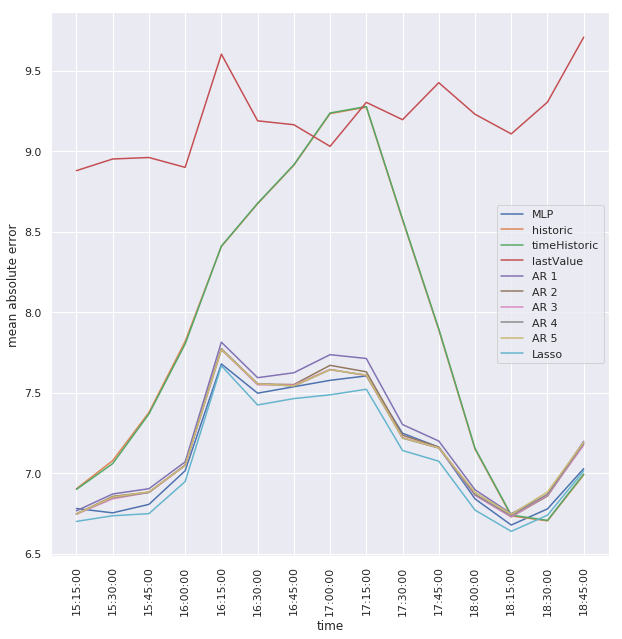

In [461]:
plt.figure(figsize=(10,10))
mc.plotTimeError()

In [91]:
deepMLPLasso??

Signature: deepMLPLasso(rate)
Docstring: <no docstring>
Source:   
def deepMLPLasso(rate):
    main_input = tf.keras.layers.Input( x_train_00.shape[1:], name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )
    hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(flatten_input)
    hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(hidden)

    output_layer=tf.keras.layers.Dense(nSegments, name="speed_lstm",kernel_regularizer = tf.keras.regularizers.l1(rate))( hidden)
    
    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss="mse", optimizer=optimizer,metrics=["mse"])
    data_model.model.summary()
File:      /home/dsi/mbouchouia/code/git/PRIM/Notebooks/<ipython-input-70-44abcd82cfe1>
Type:      function


In [238]:
alpha_max=1e-3
eps=0.01
n_alphas=10
alphas =np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),
                       num=n_alphas)[::-1]
alphas =np.r_[alpha_max*eps:alpha_max:10j]    
alphas

array([1.0e-05, 1.2e-04, 2.3e-04, 3.4e-04, 4.5e-04, 5.6e-04, 6.7e-04,
       7.8e-04, 8.9e-04, 1.0e-03])

In [506]:
alpha_max=0.015
eps=0.4
n_alphas=10
alphas =np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),
                       num=n_alphas)[::-1]
alphas =np.r_[alpha_max*eps:alpha_max:10j]  
alphas

array([0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013, 0.014,
       0.015])

In [567]:
alpha_max=0.015
eps=0.4
n_alphas=10
alphas =np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),
                       num=n_alphas)[::-1]
alphas =np.r_[alpha_max*eps:alpha_max:10j]  
alphas

array([0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018,
       0.02 ])

In [82]:
alpha_max=0.00001
eps=0.1
n_alphas=10
alphas =np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),
                       num=n_alphas)[::-1]
alphas =np.r_[alpha_max*eps:alpha_max:10j]    


def FFLSTM(data_model,x_train_00,rate=0.9e-05):
    main_input = tf.keras.layers.Input( x_train_00.shape[1:], name="speed_input")
    
    lstm_layer=tf.keras.layers.LSTM(nSegments, name="speed_lstm0",
                                    kernel_regularizer = tf.keras.regularizers.l1(rate),
                                    recurrent_regularizer = tf.keras.regularizers.l1(rate))( main_input)
    lstm_layer=tf.keras.layers.Dense(nSegments,kernel_regularizer = tf.keras.regularizers.l1(rate))( lstm_layer)

    
    output_layer=tf.keras.layers.Dense(nSegments, name="OUTPUT",kernel_regularizer = tf.keras.regularizers.l1(rate))( lstm_layer)

    data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])
    
    optimizer = tf.keras.optimizers.Adam()
    data_model.model.compile(loss="mse", optimizer=optimizer,metrics=["mse"])
    data_model.model.summary()



def deepMLPLasso(data_model,x_train_00,rate):
        main_input = tf.keras.layers.Input( x_train_00.shape[1:], name="speed_input")

#         flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )
        flatten_input = tf.keras.layers.Flatten()(main_input )
        hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(flatten_input)
        hidden = tf.keras.layers.Dense(nSegments,activation="tanh",kernel_regularizer = tf.keras.regularizers.l1(rate))(hidden)

        output_layer=tf.keras.layers.Dense(nSegments, name="speed_lstm",kernel_regularizer = tf.keras.regularizers.l1(rate))( hidden)

        data_model.model = tf.keras.Model(inputs = [main_input], outputs= [output_layer])

        optimizer = tf.keras.optimizers.Adam()
        data_model.model.compile(loss="mse", optimizer=optimizer,metrics=["mse"])
        data_model.model.summary()


def simpleMonoInput(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

    output_layer = tf.keras.layers.Dense(nSegments,
                                         kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                                         name = "Output", 
                                         use_bias = True
                                        )(flatten_input)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
        
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mse'] )

    data_model.model.summary()
    
    
    

def model(space):
    nSegments = len(speedDF)
    
    
    
    input_lag, output_lag, sequence_length = 1, 1, 20 # speedDF.columns.size
    


    params        = { "scale_output" :True,"name":"MLP",'segmentWiseNormalization':True }
    
    data_model    = models.DataModel( speedDF,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params)

    data_model.preprocessData()

    x_train_00, y_train_00, x_test_00, y_test_00 = data_model.trainSplit()


    tf.keras.backend.clear_session()
    # data_model.count_data = count_data

    simpleMonoInput(data_model,x_train_00,space['l1_rate'])
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_mean_squared_error', factor = 0.5, verbose=1, patience=5, cooldown=5)
    early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_mean_squared_error', patience = 20, restore_best_weights=True)

    batch_size = 8

    modelHist = data_model.model.fit([x_train_00], [y_train_00], validation_data = ([x_test_00],[y_test_00]), batch_size=batch_size,epochs=400, callbacks=[reduce_lr,early_stop],verbose=0)
    result = {
            "loss":       data_model.mse(data_model.predict('test'),y_test_00),
            "mae":        data_model.mae(data_model.predict('test'),y_test_00),
            "t_loss":     data_model.mse(data_model.predict('train'),y_train_00),
            "t_mae":      data_model.mae(data_model.predict('train'),y_train_00),
            "status": STATUS_OK,
            ** space
        }
    print('returning results')
    print(result)
    return result


all_results=[]
for a in alphas:
    space = {
        'l1_rate':a,
        't':  "case[0]",
        'left':" case[2]"
    }

    all_results.append(model(space))


# trials = Trials()

# best = fmin(
#     fn=model,
#     space=space,
#     algo=tpe.suggest,
#     trials=trials,
#     max_evals=3
# )


# def trialsAsDF(trials):
    
#     return pd.DataFrame([trials.trials[i]['result']['space'] for i in range(len(trials.trials)-1)]).assign(loss =[trials.trials[i]['result']['loss'] for i in range(len(trials.trials)-1)] )

# trialsAsDF(trials).sort_values('loss')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
speed_input (InputLayer)     [(None, 1, 556)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 556)               0         
_________________________________________________________________
Output (Dense)               (None, 556)               309692    
Total params: 309,692
Trainable params: 309,692
Non-trainable params: 0
_________________________________________________________________

Epoch 00041: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 3.12

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]),
 <a list of 8 Text xticklabel objects>)

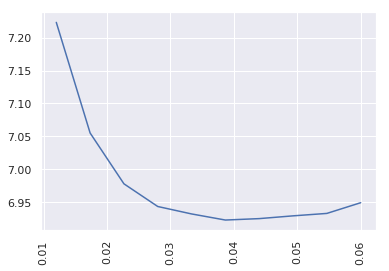

In [81]:
plt.plot(*pd.DataFrame(all_results)[['l1_rate','mae']].values.swapaxes(0,1))
plt.xticks(rotation=90)

In [40]:
speedDF= pd.read_pickle("full_day_spped_df.pckl")

In [41]:
all_results_df = pd.read_pickle("allresults_vf3.pckl")
# all_results_df = pd.read_pickle("allresults_tmp.pckl")

In [42]:
A1_results=all_results_df[['loss','t','left']][all_results_df['left']==True]

A1_results=A1_results.assign(weighted_loss_A1=A1_results.apply(lambda x: (x['t'])*x['loss'] ,axis=1))

In [43]:
A2_results=all_results_df[['loss','t','left']][all_results_df['left']==False]

A2_results=A2_results.assign(weighted_loss_A2=A2_results.apply(lambda x: (55-x['t'])*x['loss'] ,axis=1))

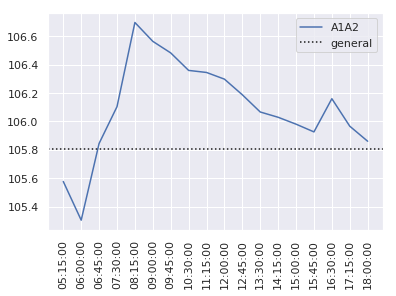

In [45]:
quarters = np.unique(pd.to_datetime(speedDF.columns).time)
quarters.sort()

weithed_sum=((A1_results.groupby('t').min()['weighted_loss_A1']+A2_results.groupby('t').min()['weighted_loss_A2'])/55)
plt.plot(weithed_sum,label='A1A2')

plt.axhline(105.80747349038776,label="general",color='k',linestyle=":")
plt.xticks(ticks=weithed_sum.index, labels=[quarters[t] for t in weithed_sum.index],rotation = 90);
plt.legend();

In [46]:
lassopreds = models_predictions['Lasso']
idxs=[]
quarters = np.unique(pd.to_datetime(speedDF.columns).time)

for t in range(2,20):

    idxs.append([True if x in quarters[:t]  else False for x in pd.to_datetime(lassopreds.columns).time ])

left_global_error=[mc.mse(speedDF[lassopreds.columns[idx]].values.flatten(),lassopreds[lassopreds.columns[idx]].values.flatten()) for idx in idxs]

idxs=[]
for t in range(2,20):

    idxs.append([True if x not in quarters[:t]  else False for x in pd.to_datetime(lassopreds.columns).time ])

right_global_error=[mc.mse(speedDF[lassopreds.columns[idx]].values.flatten(),lassopreds[lassopreds.columns[idx]].values.flatten()) for idx in idxs]



NameError: name 'models_predictions' is not defined

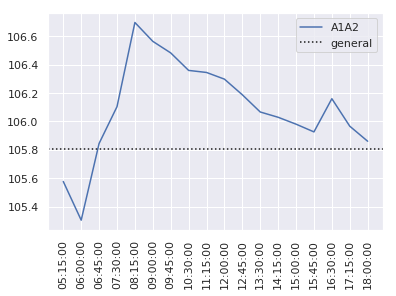

In [49]:
quarters = np.unique(pd.to_datetime(speedDF.columns).time)
quarters.sort()

weithed_sum=((A1_results.groupby('t').min()['weighted_loss_A1']+A2_results.groupby('t').min()['weighted_loss_A2'])/55)
plt.plot(weithed_sum,label='A1A2')

plt.axhline(105.80747349038776,label="general",color='k',linestyle=":")
plt.xticks(ticks=weithed_sum.index, labels=[quarters[t] for t in weithed_sum.index],rotation = 90);
plt.legend();

In [50]:
A2_results.groupby('t').min()['loss']

t
1     105.712992
4     105.082399
7     104.121085
10    102.658730
13    101.210671
16    100.885518
19    101.241422
22    101.930603
25    103.080215
28    102.654935
31    102.765371
34    104.340826
37    106.184913
40    108.480531
43    110.342327
46    108.853350
49    104.194526
52    104.171034
Name: loss, dtype: float64

NameError: name 'right_global_error' is not defined

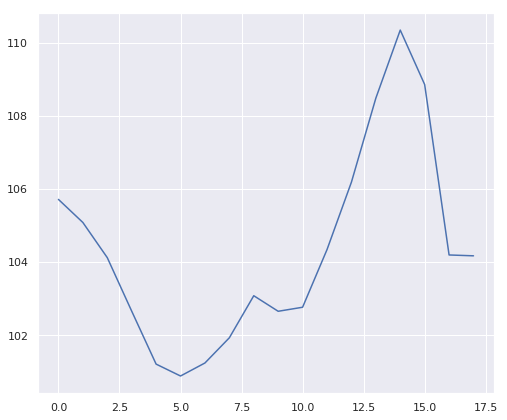

In [51]:

plt.figure(figsize=(18,7))
plt.subplot(121)
plt.plot(A2_results.groupby('t').min()['loss'].values,label='A2')
plt.plot(right_global_error,label="general")
plt.xticks(ticks=weithed_sum.index-1, labels=[quarters[t] for t in weithed_sum.index],rotation = 90);
plt.legend();

plt.subplot(122)
plt.plot(A1_results.groupby('t').min()['loss'].values,label='A1')
plt.plot(left_global_error,label="general")
plt.xticks(ticks=weithed_sum.index-1, labels=[quarters[t] for t in weithed_sum.index],rotation = 90);
plt.legend();

In [52]:
grps=all_results_df[['l1_rate','left','loss','t']].groupby(['t'])

In [53]:
grp1=grps.get_group(1)

In [54]:
grp1t=grp1.groupby('left').get_group(1).set_index('l1_rate')
grp1f=grp1.groupby('left').get_group(0).set_index('l1_rate')

In [60]:
def plot_groups_loss(grps):
    t_index=all_groups.index.levels[0]
    nb_plots=len(t_index)
    nrows = np.sqrt(nb_plots)//1+1
    for i in t_index:
        grps.loc[i].plot(ax=plt.subplot(nrows,nrows,i),title = 't='+str(quarters[i]))
        plt.ylabel('MSE')
        plt.xlabel("Alpha")

In [59]:
def get_inner_group_loss_to_rate(grps):
    inner_grps=grps.groupby('left')
    grp1t=inner_grps.get_group(1).set_index('l1_rate')
    grp1f=inner_grps.get_group(0).set_index('l1_rate')
    joined_grp=grp1t.join(grp1f,how="inner",on="l1_rate",lsuffix="_before_t",rsuffix="_after_t")[['loss_before_t','loss_after_t']]
    return joined_grp

In [62]:
all_groups = grps.apply(get_inner_group_loss_to_rate )

In [63]:
midx=all_groups.index

ValueError: num must be 1 <= num <= 25, not 28

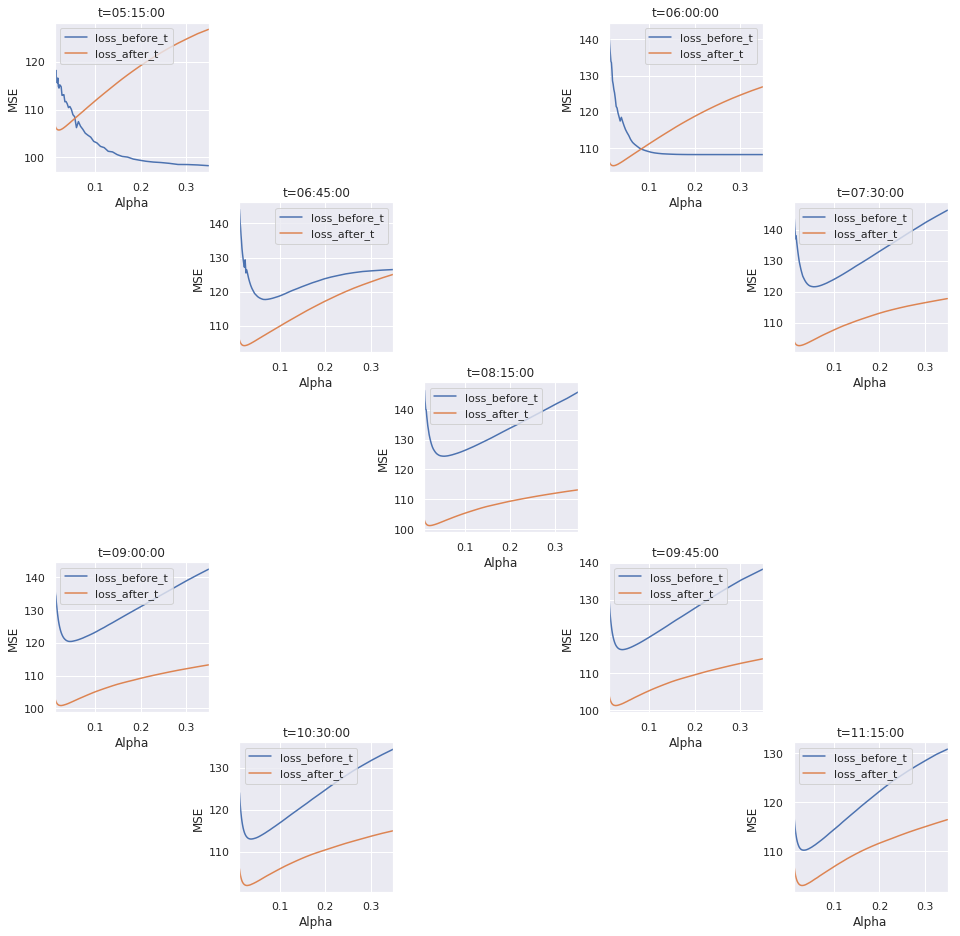

In [64]:
plt.figure(figsize=(16,16))
plot_groups_loss(all_groups)
plt.tight_layout()

In [ ]:
grp1.apply()

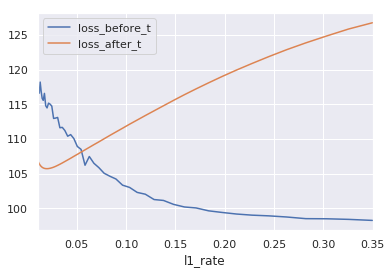

In [65]:
grp1t.join(grp1f,how="inner",on="l1_rate",lsuffix="_before_t",rsuffix="_after_t")[['loss_before_t','loss_after_t']].plot()

left
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

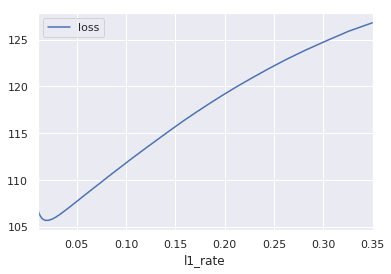

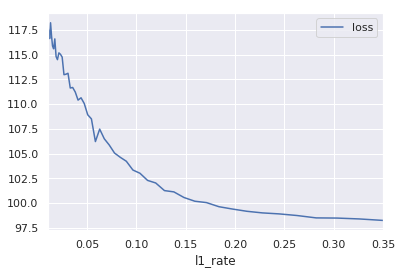

In [66]:
grp1.groupby('left').plot(x='l1_rate',y='loss')

# A matrix for each time

In [23]:
def split_time(df,t_interval_length = 2,overlapping = True):
    t_index  = np.unique(pd.to_datetime(df.columns).time)
    index_subsets = np.split(t_index,range(t_interval_length,len(t_index),t_interval_length)) if not overlapping else np.array([np.array([t_index[i]  for i in range(j,t_interval_length+j)]) for j in range(len(t_index)-t_interval_length+1)])
    index_subsets = [ pd.Index(pd.to_datetime(df.columns).time).isin(subset) for subset in index_subsets]
    return index_subsets

In [24]:
index_subsets=split_time(speedDF,2)

In [25]:
alpha_max=2
eps=0.05
n_alphas=100
alphas =np.logspace(np.log10(alpha_max * eps), np.log10(alpha_max),
                       num=n_alphas)[::-1]
# alphas =np.r_[alpha_max*eps:alpha_max:10j] 
alphas




# pruning_params = {
#       'pruning_schedule': sparsity.ConstantSparsity(.99,0,frequency=2)
# }


def simpleMonoInput(data_model,x_train,l1_rate):
    """
    params        = { "shift_mean":True, "scale_output":True}

    97.82098577640886 104.90778000413427
    
    6.814727330233829 7.017203929831204
    
    """
    
#     time_dense = tf.keras.layers.Dense( nSegments, use_bias=False )(time_input)
    
    
    
    
    main_input = tf.keras.layers.Input(x_train.shape[1:],name="speed_input")
    
    flatten_input = tf.keras.layers.Lambda(lambda x : x[:,-1,:])(main_input )

    output_layer = tf.keras.layers.Dense(nSegments, kernel_regularizer=tf.keras.regularizers.l1(l1_rate) , name = "Output", use_bias = False)(flatten_input)
    
    data_model.model = tf.keras.Model( inputs = [ main_input ], outputs= [ output_layer ])
    
    optimizer = tf.keras.optimizers.Adam()
    
#     data_model.model=sparsity.prune_low_magnitude(  data_model.model, **pruning_params)
    
    data_model.model.compile( loss = "mse", optimizer = optimizer, metrics = ['mse'] )
    



t_interval_length = 2
overlapping = True
t_index  = np.unique(pd.to_datetime(speedDF.columns).time)

index_subsets =  split_time(speedDF,t_interval_length,overlapping)

K = tf.keras.backend

A_t = []
losses = []
maes=[]
full_preds,full_y = [],[]
A_t_model=None
all_AT =None
try:
    err_rates
except Exception:
    err_rates =np.zeros(len(index_subsets))
    
for i,subset in enumerate(index_subsets) :
    print("subset = "+str(i))
    best_preds=None
    best_loss=sys.float_info.max
    for rate in alphas:
        X = speedDF[speedDF.columns[subset]].copy()
        nSegments = len(X)
        input_lag, output_lag, sequence_length = 1, 1, t_interval_length # speedDF.columns.size

        time_intercept = intercept_extended_df[intercept_extended_df.columns[subset]].copy()
        time_intercept_model=models.DataModel(time_intercept, input_lag, output_lag, sequence_length, valid_split = valid_split,scale_output=True)

        params        = { "scale_output" : True}


        A_t_model    = models.DataModel( X,    input_lag, output_lag, sequence_length, valid_split = valid_split, **params)                                                

        A_t_model.preprocessData()

        A_t_x_train_00, A_t_y_train_00, A_t_x_test_00, A_t_y_test_00 = A_t_model.trainSplit()

        tf.keras.backend.clear_session()

        simpleMonoInput(A_t_model,A_t_x_train_00,l1_rate=rate)

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor = 'val_mean_squared_error', factor = 0.8, verbose=0, patience=5, cooldown=5)
        early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_mean_squared_error', patience = 10, restore_best_weights=True )
        batch_size = 8

        modelHist = A_t_model.model.fit([A_t_x_train_00], [A_t_y_train_00], validation_data=([A_t_x_test_00],A_t_y_test_00),verbose=0, batch_size=batch_size,epochs=400,callbacks=[reduce_lr,early_stop])
        loss =  A_t_model.mse(A_t_model.predict('test'),A_t_y_test_00)
        
        print("alpha ",rate,"loss ",loss,'train ',A_t_model.mse(A_t_model.predict('train'),A_t_y_train_00))
        if loss < best_loss and abs(A_t_model.mse(A_t_model.predict('train'),A_t_y_train_00)/loss)<0.75 :
            best_loss=loss
            best_preds = A_t_model.restorePredictionsAsDF(A_t_model.predict('test'),'test')
        
    if i==0:
        all_AT=best_preds
    else : 
        all_AT=pd.concat([all_AT,best_preds],axis=1)
        

all_AT.sort_index(axis=1,inplace=True)


subset = 0
alpha  2.0 loss  99.18385240814423 train  101.47107005227427
alpha  1.940386652453298 loss  99.1920375070308 train  101.4339804328012
alpha  1.8825501805094587 loss  99.18671483335368 train  101.86422611394768
alpha  1.82643762141705 loss  99.08527292670182 train  101.17015700910409
alpha  1.7719975910680972 loss  99.19178020665406 train  101.24543461187595
alpha  1.7191802369439673 loss  99.17235485647647 train  101.33309308003881
alpha  1.6679371924637858 loss  99.18395616212393 train  101.30884244903687
alpha  1.6182215326935794 loss  99.12952448574754 train  101.0014928293804
alpha  1.5699877313755697 loss  99.18944318818885 train  101.69048511486619
alpha  1.523191619238295 loss  99.18408779157284 train  101.76581588358393
alpha  1.4777903435493567 loss  99.1656884179368 train  100.90361344034973
alpha  1.4337423288737734 loss  99.01567290683613 train  100.6510860595012
alpha  1.391007239001988 loss  99.17091958780954 train  101.05906506174074
alpha  1.3495459400126866 

In [27]:
all_AT.columns[:20]

DatetimeIndex(['2019-02-13 14:15:00', '2019-02-13 14:30:00',
               '2019-02-13 14:45:00', '2019-02-13 15:00:00',
               '2019-02-13 15:15:00', '2019-02-13 15:30:00',
               '2019-02-13 15:45:00', '2019-02-13 16:00:00',
               '2019-02-13 16:15:00', '2019-02-13 16:30:00',
               '2019-02-13 16:45:00', '2019-02-13 17:00:00',
               '2019-02-13 17:15:00', '2019-02-13 17:30:00',
               '2019-02-13 17:45:00', '2019-02-13 18:00:00',
               '2019-02-13 18:15:00', '2019-02-13 18:30:00',
               '2019-02-13 18:45:00', '2019-02-14 14:15:00'],
              dtype='datetime64[ns]', freq=None)

In [28]:
all_AT.to_pickle('time_specific_model_preds.pckl')

In [26]:
all_AT

,2019-02-13 14:15:00,2019-02-13 14:30:00,2019-02-13 14:45:00,2019-02-13 15:00:00,2019-02-13 15:15:00,2019-02-13 15:30:00,2019-02-13 15:45:00,2019-02-13 16:00:00,2019-02-13 16:15:00,2019-02-13 16:30:00,...,2019-03-13 16:30:00,2019-03-13 16:45:00,2019-03-13 17:00:00,2019-03-13 17:15:00,2019-03-13 17:30:00,2019-03-13 17:45:00,2019-03-13 18:00:00,2019-03-13 18:15:00,2019-03-13 18:30:00,2019-03-13 18:45:00
newIndex,,,,,,,,,,,,,,,,,,,,,
10275171_0,0.714100,0.464607,0.126081,0.086335,-1.239798,1.221216,0.033395,0.091363,0.178171,0.368532,...,-0.888922,0.060590,0.164660,0.545598,0.048165,-0.128300,0.184992,1.184045,0.346870,1.506043
11027377_0,0.731120,0.163037,1.375715,0.445731,-0.205882,-0.043363,0.818342,-1.971022,0.743131,-4.915857,...,-1.186919,-2.076807,-0.202581,-1.589818,1.849881,0.339929,-1.789967,-1.125096,0.779075,-1.822460
11027379_0,-0.164692,0.058541,-0.085250,-0.076311,-1.024816,2.063162,-0.179969,1.213683,1.299223,5.813837,...,3.346087,-0.598838,1.258656,6.348205,2.786034,0.700248,-0.498426,-0.264893,-1.596868,0.351796
111437857_0,0.605205,0.798303,3.895614,0.976342,6.671044,4.367518,2.527170,13.404612,8.715740,17.007122,...,1.913449,-15.652798,3.625777,15.476819,12.849121,10.958881,4.717258,2.024504,0.090794,-1.837351
111850247_0,1.347399,0.735841,-0.946725,0.180322,0.063676,-0.024880,0.065334,0.017362,0.093291,0.957659,...,-0.904401,0.579587,0.888832,0.693348,2.257196,1.715771,1.069154,1.851564,0.073596,-0.050384
115616573_0,0.038459,0.026979,-0.008443,0.076144,0.054413,0.032073,0.091235,-0.037822,0.974860,0.874569,...,0.080107,1.249720,1.716206,1.392655,0.674289,2.902936,0.766867,1.358233,0.024199,-0.128290
116545002_0,1.102002,0.062907,0.022764,-0.081602,0.451979,0.137416,0.117958,1.007908,6.269180,1.157042,...,0.371383,-1.756400,1.666633,1.068394,1.393822,0.274936,0.010203,0.722967,0.139114,-0.624997
116545010_0,0.041052,0.093845,0.027202,-0.052741,-0.085987,-0.963857,-0.103314,-5.979761,0.179204,1.912521,...,-3.391666,2.544189,-0.217050,-0.455034,-0.011823,0.053493,0.107241,0.283931,-0.003294,-0.032759
117462713_0,-0.055891,-0.389729,-0.002222,-0.002988,0.081143,0.011420,0.051991,0.117016,0.022797,0.575791,...,0.249126,1.556112,0.666211,1.168430,0.743195,0.137864,0.144416,-0.156291,0.007182,0.256230


In [ ]:
multi_model_plotting = models.ModelPlots(None,None,y=full_y,preds=full_preds)

In [ ]:
fig = plt.figure(figsize=(18,18))
ax=plt.gca()
lastValue_model_plotting.plotDiscreteSpeedError(ax,"last_value")
timehistoric_model_plotting.plotDiscreteSpeedError(ax,"timehistoric")

historic_model_plotting.plotDiscreteSpeedError(ax,"historic")
AR5_model_plotting.plotDiscreteSpeedError(ax,"AR")
model_plotting.plotDiscreteSpeedError(ax,"Current model")
multi_model_plotting.plotDiscreteSpeedError(ax,"Multi model")

if not oldModelPlotting is None :
    oldModelPlotting.plotDiscreteSpeedError(ax,"old")
else :
    oldModelPlotting=model_plotting
ax.twinx()
plt.plot(*np.unique((data_model.trainSplit()[3]+intercept_data_model.trainSplit()[3]).flatten().round(),return_counts=True), 'k:', linewidth=2,label="count", alpha=0.4);
plt.ylabel("counts")


In [ ]:
plt.plot(maes)

In [ ]:
# number of  ones
plt.plot(np.sum( A_t, (1,2)))
plt.title("Number of Ones for each matrix At")

In [ ]:
one_matches= np.array([np.sum(A_t[i]+A_t[j]==2)  for i, j in list(itertools.combinations(range(len(A_t)),2))])

mismatches=np.array([np.sum(abs(A_t[i]-A_t[j]))  for i, j in list(itertools.combinations(range(len(A_t)),2))])
# plt.plot(mismatches)
plt.plot(one_matches)
plt.title("number of 1-matches between At matrices")